In [1]:
from binance.client import Client
from binance.enums import *
from binance.cm_futures import CMFutures

import numpy as np
import pandas as pd
import numpy.matlib as matlib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
import warnings
warnings.filterwarnings('ignore') 

#### Setting plotting and display options

np.set_printoptions(precision = 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option('display.max_rows', 10)

plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14
%matplotlib inline

In [2]:
#API
api_key = ''
api_secret = ''

client = Client(api_key,api_secret)

In [3]:
def clean_dataframe(df, missing_threshold=0.1):
    missing_frac = df.isnull().mean()
    drop_list = missing_frac[missing_frac > missing_threshold].index
    df_cleaned = df.drop(labels=drop_list, axis=1)
    df_cleaned = df_cleaned.fillna(method='ffill')
    return df_cleaned

def PCWeights(pca):
    weights = pd.DataFrame()
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights
    
def sharpe_ratio(ts_returns, periods_per_year = 1): # 이거 일봉이 아니라 30분봉이라 365는 사실 아님
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_return, annualized_vol, annualized_sharpe

def FindOptimalPortfolio(pca, scaled_coin, X_Train_Raw):
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0
    coin_tickers = scaled_coin.columns.values
    n_tickers = len(coin_tickers)
    PCs = pca.components_
    
    for i in range(n_portfolios):
        pc_w = PCs[i] / sum(PCs[i])

        # # Optional: Long only
        # pc_w[pc_w < 0] = 0
        # pc_w /= pc_w.sum()

        eigen_prtfi = pd.DataFrame(data = {"weights": pc_w.squeeze()*100}, index = coin_tickers)
        eigen_prtfi.sort_values(by = ["weights"], ascending = False, inplace = True)
        eigen_prti_returns = np.dot(X_Train_Raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index = X_Train_Raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
            
    highest_sharpe = np.argmax(sharpe_metric)   
    results = pd.DataFrame(data = {"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric})
    results.dropna(inplace = True)
    results.sort_values(by = ["Sharpe"], ascending = False, inplace = True)
    return results.head(15)

def VisualizeEigen(weights, coin_tickers, portfolio = pd.DataFrame()):
    portfolio = pd.DataFrame(data = {"weights": weights.squeeze()*100}, index = coin_tickers)
    portfolio.sort_values(by = ["weights"], ascending = False, inplace = True)
    return portfolio

def allocation_df(visualize_eigen, capital):
    df = visualize_eigen
    df['Position'] = df['weights'].apply(lambda x: 'Long' if x > 0 else 'Short')
    total_weights = df['weights'].abs().sum()
    df['Capital_Allocation'] = (df['weights'].abs() / total_weights) * capital
    return df

def pcaAllocation(df):
    Daily_Linear_Returns = df.pct_change(1)
    Daily_Linear_Returns = Daily_Linear_Returns[Daily_Linear_Returns.apply(lambda x:(x - x.mean()).abs() < (3 * x.std())).all(1)]
    scaler = StandardScaler().fit(Daily_Linear_Returns)
    scaled_coin = pd.DataFrame(scaler.fit_transform(Daily_Linear_Returns),
                            columns = Daily_Linear_Returns.columns,
                            index = Daily_Linear_Returns.index)
    Daily_Linear_Returns.dropna(how = "any", inplace = True)
    scaled_coin.dropna(how = "any", inplace = True)
    coin_tickers = scaled_coin.columns.values
    n_tickers = len(coin_tickers)
    X_Train = scaled_coin
    X_Train_Raw = Daily_Linear_Returns
    pca = PCA()
    PrincipalComponent = pca.fit(X_Train)
    df1 = FindOptimalPortfolio(pca, scaled_coin, X_Train_Raw)
    positive_return_df_excluding_row_0 = df1[(df1['Return'] > 0) & (df1.index != 0)]
    
    # Highest Sharpe while return is positive. Throws error if not found
    highest_return_row_with_conditions = positive_return_df_excluding_row_0['Sharpe'].idxmax()

    target_weight_int = highest_return_row_with_conditions
    portfoilio_weight_df = VisualizeEigen(weights = PCWeights(pca)[target_weight_int], coin_tickers = coin_tickers)
    execution_df = allocation_df(portfoilio_weight_df, 1)
    capital_allocation = portfoilio_weight_df['weights'] / abs(portfoilio_weight_df['weights']).sum()
    return capital_allocation

In [4]:
# # Specific Coins
# coin = []

# # Layer1 Coins
# layer1_coin_list = ['ETH', 'SUI', 'ADA', 'AVAX', 'BNB', 'TIA', 'ALT', 'CFX', 'SOL',
#                     'ETC', 'SEI', 'TRX', 'DOT', '1000LUNC', 'ONDO', 'ATOM', 'APT',
#                     'HBAR', 'ICP', 'FTM', 'EOS', 'RONIN', 'STX', 'LSK', 'CELO', 'CHZ',
#                     'AMB', 'LUNA2', 'NEO', 'ROSE', 'IOTA', 'ALGO', 'XEM', 'EGLD', 'KSM',
#                     'WAVES', 'XTZ', 'FLOW', 'VET', 'MOVR', 'NTRN', 'KAVA', 'POLYX',
#                     'ZIL', 'QTUM', 'IOTX', 'ONT', 'KLAY', 'IOST', 'ICX', 'ONG']
# layer1_coin_list_with_usdt = [coin + 'USDT' for coin in layer1_coin_list]

# # Extraction of historical price
# date_now = dt.datetime.now()
# date_start = date_now - dt.timedelta(days=365)
# now = date_now.strftime("%Y-%m-%d %H:%M:%S")
# start = date_start.strftime("%Y-%m-%d")
# data_frames = []

# for symbol in layer1_coin_list_with_usdt:
#     print(symbol)
#     print(dt.datetime.now())
#     df = pd.DataFrame(client.futures_historical_klines(
#         symbol=symbol,
#         interval=client.KLINE_INTERVAL_1HOUR, 
#         start_str=start,
#         end_str=now
#     ))
#     df = df.iloc[:, :6]
#     df.columns = ['date', 'open', 'high', 'low', f'{symbol}', 'volume']
#     df['date'] = pd.to_datetime(df['date'], unit='ms')
#     for col in df.columns[1:]:
#         df[col] = pd.to_numeric(df[col])
#     df = df.set_index("date")
#     data_frames.append(df[symbol])

# data = pd.concat(data_frames, axis=1)
# data.to_csv("layer1_365d_1hr.csv")

In [5]:
# Load csv file
df = pd.read_csv("layer1_365d_1min.csv", index_col= 0)

# To adjust size of df
df = clean_dataframe(df).dropna()[:round(len(df)*0.5)] #BEAR season
# df = clean_dataframe(df).dropna()[-round(len(df)*0.5):] #BULL season
df

,ETHUSDT,ADAUSDT,AVAXUSDT,BNBUSDT,CFXUSDT,SOLUSDT,ETCUSDT,TRXUSDT,DOTUSDT,1000LUNCUSDT,...,FLOWUSDT,VETUSDT,KAVAUSDT,ZILUSDT,QTUMUSDT,IOTXUSDT,ONTUSDT,KLAYUSDT,IOSTUSDT,ICXUSDT
date,,,,,,,,,,,,,,,,,,,,,
2023-03-30 12:00:00,1804.070,0.381,17.389,317.350,0.424,20.684,20.440,0.065,6.162,0.122,...,0.982,0.023,0.902,0.028,3.095,0.026,0.228,0.233,0.010,0.218
2023-03-30 12:01:00,1803.340,0.380,17.370,317.150,0.423,20.658,20.416,0.065,6.157,0.122,...,0.981,0.023,0.901,0.028,3.092,0.026,0.228,0.232,0.010,0.218
2023-03-30 12:02:00,1801.600,0.380,17.327,316.870,0.422,20.625,20.394,0.065,6.150,0.122,...,0.979,0.023,0.902,0.028,3.089,0.026,0.227,0.232,0.010,0.217
2023-03-30 12:03:00,1801.430,0.380,17.324,316.620,0.425,20.603,20.388,0.065,6.148,0.122,...,0.977,0.023,0.902,0.028,3.088,0.026,0.227,0.232,0.010,0.217
2023-03-30 12:04:00,1800.900,0.380,17.316,316.520,0.427,20.592,20.379,0.065,6.147,0.122,...,0.976,0.023,0.902,0.028,3.087,0.026,0.227,0.232,0.010,0.217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29 03:51:00,1649.880,0.250,9.321,214.880,0.126,20.157,15.781,0.088,4.070,0.063,...,0.447,0.017,0.629,0.017,2.221,0.015,0.166,0.114,0.008,0.175
2023-09-29 03:52:00,1650.240,0.250,9.327,214.910,0.126,20.174,15.783,0.088,4.072,0.063,...,0.447,0.017,0.629,0.017,2.224,0.015,0.166,0.114,0.008,0.174
2023-09-29 03:53:00,1650.430,0.250,9.331,214.930,0.126,20.186,15.789,0.088,4.073,0.063,...,0.447,0.017,0.630,0.017,2.223,0.015,0.166,0.114,0.008,0.174


# Backtest with specific params

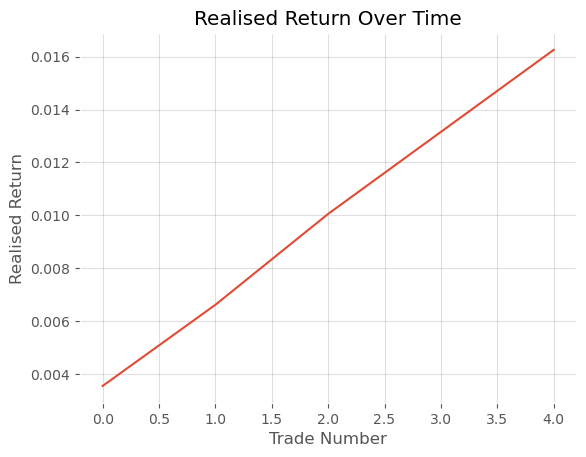

 START: 2023-04-29 12:00:00         
 END: 2023-09-29 03:55:00         
 PNL: 0.016257134620519385         
 UNPNL: -0.11877377182999353         
 MDD_UNPNL: -0.14879047387768635         
 WIN: 5         
 LOSE: 0         
 W/L: inf         
 TRADE DATE: ['2023-04-29 12:00:00', '2023-05-01 02:06:00', '2023-05-03 18:41:00', '2023-05-03 21:08:00', '2023-05-03 22:02:00', '2023-05-04 03:48:00']


In [6]:
window = 60 * 24 * 30 # 30 days of 1m interval data
test_window = window * 100 #0.2 #train:test 80:20
position_window = 0

TP = 0.003 # BEAR 0.003 BULL 0.10
SL = -1
results = []
realised_return = 0
realised_return_series = []  # Step 1: Initialize a list to store realised_return over time
unrealised_MDD = 0

win_count = 0
lose_count = 0

dates_list = []

in_position = False

for i in range(window, len(df)):
    try:
        if not in_position:
            initial_price = df.iloc[i]
            try:
                capital_allocation = pcaAllocation(df[i-window: i])
            except ValueError as e:
                continue

            for coin, allocation in capital_allocation.items():
                results.append({'coin': coin, 'capital_allocation': allocation, 'initial_price': initial_price[coin]})
            
            in_position = True
            position_window = 0
            dates_list.append(df.index[i])
            continue

        else:
            unrealised_return = 0
            current_price = df.iloc[i]
            position_window += 1
            for result in results:
                coin = result['coin']
                initial_price_coin = result['initial_price']
                capital_allocation_coin = result['capital_allocation']
                current_price_coin = current_price[coin]

                pnl = (current_price_coin - initial_price_coin) / initial_price_coin * capital_allocation_coin
                            
                unrealised_return += pnl

            unrealised_MDD = min(unrealised_return, unrealised_MDD)

            if unrealised_return > TP or unrealised_return < SL or position_window > test_window:
                realised_return += unrealised_return
                realised_return_series.append(realised_return)  # Step 2: Append the current realised_return to the list
                # dates_list.append(df.index[i])

                if unrealised_return > TP:
                    win_count += 1
                elif unrealised_return < SL:
                    lose_count += 1

                results = []
                in_position = False
    except Exception as e:
        continue

# After the loop completes
realised_returns = pd.Series(realised_return_series)  # Step 3: Convert the list into a pandas Series

# Step 4: Plot the Series
import matplotlib.pyplot as plt

plt.plot(realised_returns.index, realised_returns.values)
plt.xlabel('Trade Number')
plt.ylabel('Realised Return')
plt.title('Realised Return Over Time')
plt.show()

if lose_count != 0:
    win_loss_ratio = win_count / lose_count
else:
    win_loss_ratio = float('inf')

print(f' START: {df.index[window]} \
        \n END: {df.index[-1]} \
        \n PNL: {realised_return} \
        \n UNPNL: {unrealised_return} \
        \n MDD_UNPNL: {unrealised_MDD} \
        \n WIN: {win_count} \
        \n LOSE: {lose_count} \
        \n W/L: {win_loss_ratio} \
        \n TRADE DATE: {dates_list}')

# Backtest for params tuning

In [7]:
def pcaBacktester(n, TP, SL, df):
    window = 60 * n
    results = []
    realised_return = 0
    win_count = 0
    lose_count = 0
    in_position = False

    realised_return_series = []

    for i in range(window, len(df)):ㅠ
        try:
            if not in_position:
                initial_price = df.iloc[i]
                try:
                    capital_allocation = pcaAllocation(df[i-window: i])
                except ValueError as e:
                    continue

                for coin, allocation in capital_allocation.items():
                    results.append({'coin': coin, 'capital_allocation': allocation, 'initial_price': initial_price[coin]})
                
                in_position = True
                continue

            else:
                unrealised_return = 0
                current_price = df.iloc[i]
                
                for result in results:
                    coin = result['coin']
                    initial_price_coin = result['initial_price']
                    capital_allocation_coin = result['capital_allocation']
                    current_price_coin = current_price[coin]

                    pnl = (current_price_coin - initial_price_coin) / initial_price_coin * capital_allocation_coin                            
                    unrealised_return += pnl

                if unrealised_return > TP or unrealised_return < SL:
                    realised_return += unrealised_return
                    realised_return_series.append(realised_return)
                    if unrealised_return > TP:
                        win_count += 1
                    elif unrealised_return < SL:
                        lose_count += 1

                    results = []
                    in_position = False
        
        except Exception as e:
            continue


    trade_count = win_count + lose_count
    win_loss_ratio = win_count / lose_count if lose_count != 0 else float('inf')

    return realised_return, unrealised_return, win_count, lose_count, win_loss_ratio, trade_count

IndentationError: unexpected indent (1920979964.py, line 12)

In [ ]:
# Parameters
n_values = [7, 14, 30, 60, 120]
TP_values = [0.005, 0.01, 0.02, 0.03]
SL_values = [-0.005, -0.01, -0.02, -0.03]

# DataFrame to store results
results_df = pd.DataFrame(columns=['n', 'TP', 'SL', 'realised_return', 'unrealised_return', 'win_count', 'lose_count', 'win_loss_ratio', 'trade_count'])

# Iterate over all combinations of parameters
for n in n_values:
    for TP in TP_values:
        for SL in SL_values:
            print(n, TP, SL)
            result = pcaBacktester(n, TP, SL, df)
            results_df = results_df.append({
                'n': n*24, 'TP': TP, 'SL': SL,
                'realised_return': result[0], 'unrealised_return': result[1],
                'win_count': result[2], 'lose_count': result[3],
                'win_loss_ratio': result[4], 'trade_count': result[5]
            }, ignore_index=True)

# Sort by realised return in descending order
results_df.sort_values(by='realised_return', ascending=False, inplace=True)

results_df.to_csv('pca_1h_365d_backtest_result.csv', index=False)


7 0.005 -0.005
7 0.005 -0.01
7 0.005 -0.02
7 0.005 -0.03
7 0.01 -0.005
7 0.01 -0.01
7 0.01 -0.02
7 0.01 -0.03
7 0.02 -0.005
7 0.02 -0.01
7 0.02 -0.02
7 0.02 -0.03
7 0.03 -0.005
7 0.03 -0.01
7 0.03 -0.02
7 0.03 -0.03
14 0.005 -0.005
14 0.005 -0.01
14 0.005 -0.02
14 0.005 -0.03
14 0.01 -0.005
14 0.01 -0.01
14 0.01 -0.02
14 0.01 -0.03
14 0.02 -0.005
14 0.02 -0.01
14 0.02 -0.02
14 0.02 -0.03
14 0.03 -0.005
14 0.03 -0.01
14 0.03 -0.02
14 0.03 -0.03
30 0.005 -0.005
30 0.005 -0.01
30 0.005 -0.02
30 0.005 -0.03
30 0.01 -0.005
30 0.01 -0.01
30 0.01 -0.02
30 0.01 -0.03
30 0.02 -0.005
30 0.02 -0.01
30 0.02 -0.02
30 0.02 -0.03
30 0.03 -0.005
30 0.03 -0.01
30 0.03 -0.02
30 0.03 -0.03
60 0.005 -0.005
60 0.005 -0.01
60 0.005 -0.02
60 0.005 -0.03
60 0.01 -0.005
60 0.01 -0.01
60 0.01 -0.02
60 0.01 -0.03
60 0.02 -0.005
60 0.02 -0.01
60 0.02 -0.02
60 0.02 -0.03
60 0.03 -0.005
60 0.03 -0.01
60 0.03 -0.02
60 0.03 -0.03
120 0.005 -0.005
120 0.005 -0.01
120 0.005 -0.02
120 0.005 -0.03
120 0.01 -0.005
120 0.0